In [82]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

sns.set(style="whitegrid")
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
from tqdm import tqdm
from tqdm import trange
import time
from tqdm import tqdm, tqdm_pandas

tqdm.pandas()

### 1. Hyperparameter

In [3]:
EPOCHS=400
LR=1e-2
BS=16384
SEED=41

### 2. 시드 고정 작업

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    ## 위에서 random.seed 지정해줬는데 왜 np.random 지정해야하는지 모르겠음!!
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(200)

### 3. 데이터 불러오기

In [6]:
train_df = pd.read_csv('./input/train.csv')
train_df = train_df.drop(columns=['ID'])
print(train_df.head())

val_df = pd.read_csv('./input/val.csv')
val_df = val_df.drop(columns=['ID'])
print(val_df.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
2 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
3 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
4 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
1  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
2  0.260314 -0.568671 -0.371407  ... -0.208254 -0.559825 -0.026398 -0.371427   
3 -3.807864  0.615375  1.249376  ...  1.943465 -1.015455  0.057504 -0.649709   
4  0.851084 -0.392048 -0.410430  ... -0.073425 -0.268092 -0.204233  1.011592   

        V25       V26       V27       V28       V29       V30  
0 -0

In [7]:
#데이터 차원 확인
print(train_df.shape)
print(val_df.shape)

(113842, 30)
(28462, 31)


### 4. tsne를 이용한 데이터 차원축소 및 시각화

In [43]:
sample_X3=train_df.sample(3000)
print(sample_X3)

              V1        V2        V3        V4        V5        V6        V7  \
2928   -1.434270 -0.320887  2.580550 -2.407071 -0.067443 -0.782126 -0.402633   
59632  -2.272328 -0.766890  1.116395 -1.374367 -1.125854 -0.369560  0.196721   
91606   2.082062 -2.252156  0.722474 -1.168165 -2.488056  1.106714 -2.674972   
9530    1.184491  0.268953  0.260943  1.142464 -0.295437 -0.952762  0.262438   
1886   -4.209475 -4.389800  3.264284  4.692215  4.425014 -2.629094 -3.675024   
...          ...       ...       ...       ...       ...       ...       ...   
111008  0.195188 -0.230498 -2.132707  1.010575  0.554860  0.523462  2.611945   
95791  -0.040085  1.218856 -1.563896 -0.089413  1.075199 -1.761095  1.861717   
26546  -0.829319  0.662915  1.535039  1.660162  0.967911  1.343814  1.239029   
31849   1.317134 -1.811556  1.368467 -0.968218 -2.161918  0.916296 -2.047758   
4549    1.139176  0.176361  1.024536  2.201803 -0.540397 -0.022557 -0.407856   

              V8        V9       V10  .

In [44]:
tsne = TSNE(n_components=2, random_state=0)
X_t3 = tsne.fit_transform(sample_X3)

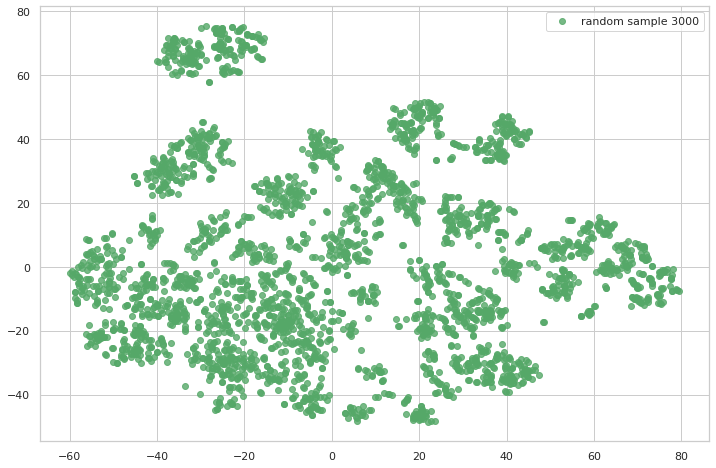

In [45]:
plt.figure(figsize=(12, 8))
plt.scatter(X_t3[:, 0], X_t3[:, 1], marker='o', color='g', linewidth=1, alpha=0.8, label='random sample 3000')

plt.legend(loc='best');
plt.show();

In [46]:
sample_X5=train_df.sample(5000)

In [47]:
tsne = TSNE(n_components=2, random_state=0)
X_t5 = tsne.fit_transform(sample_X5)

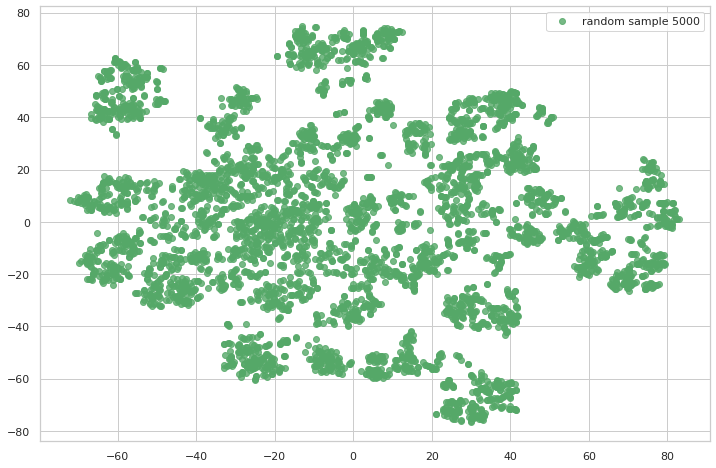

In [48]:
plt.figure(figsize=(12, 8))
plt.scatter(X_t5[:, 0], X_t5[:, 1], marker='o', color='g', linewidth=1, alpha=0.8, label='random sample 5000')

plt.legend(loc='best');
plt.show();

- 아래쪽에 떨어져있는 부분, 왼쪽 오른쪽에 떨어진 부분이 조금 수상하다.
---
### 5. Cluster Only
- 차원 축소한걸 클러스터링 해야하나 차원 축소 전을 클러스터링하고 차원축소 해야하나?
- 일단 3000개 뽑은 샘플로 둘 다 해보자

In [67]:
from sklearn.cluster import KMeans

#차원 축소 전 클러스터링
km1=KMeans(n_clusters=2,
          init='random',
          max_iter=100,
          random_state=0)
km1.fit(sample_X3)
label_km1=km1.labels_
print(label_km1)

[0 0 0 ... 0 0 0]


- kmean으로 2분류 clustering 했으므로 시각화를 위해 데이터프레임을 생성해보자.

In [76]:
X_km1_df=pd.DataFrame(sample_X3)
X_km1_df['label_km1']=label_km1
X_km1_df.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,label_km1
2928,-1.434270,-0.320887,2.580550,-2.407071,-0.067443,-0.782126,-0.402633,0.189122,2.585450,-2.166803,...,0.777323,-0.150631,0.080314,0.422285,-0.010035,0.260002,0.137860,0.279466,-0.883516,0
59632,-2.272328,-0.766890,1.116395,-1.374367,-1.125854,-0.369560,0.196721,0.234335,-0.706469,-0.510136,...,-0.124059,-0.854877,-0.066200,0.480285,-0.212745,0.067018,-0.390530,2.847202,0.059963,0
91606,2.082062,-2.252156,0.722474,-1.168165,-2.488056,1.106714,-2.674972,0.575615,0.445238,1.352857,...,0.735864,0.224539,0.776890,-0.404675,-0.031563,0.102647,-0.029111,0.132746,0.716973,0
9530,1.184491,0.268953,0.260943,1.142464,-0.295437,-0.952762,0.262438,-0.243415,-0.026831,-0.000687,...,0.112671,-0.127524,0.395106,0.678202,-0.331556,0.008110,0.025828,0.189059,-0.608900,0
1886,-4.209475,-4.389800,3.264284,4.692215,4.425014,-2.629094,-3.675024,0.642917,0.986551,0.408213,...,-0.664481,0.888551,0.314976,0.238747,0.155034,-0.095507,0.199402,0.116957,-0.946733,0


In [72]:
X = X_km1_df.drop('label_km1', axis = 1).values
#axis=0 은 행 방향으로 동작 axis=1은 열 방향으로 동작
Y = X_km1_df["label_km1"]

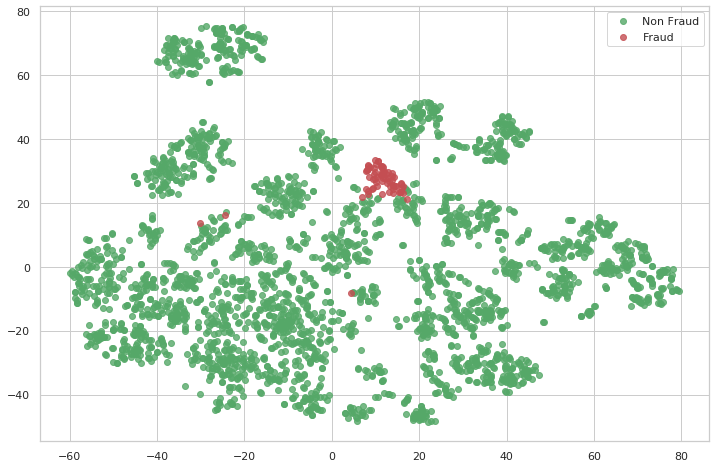

In [73]:
tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(Y == 0), 0], X_t[np.where(Y == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
plt.scatter(X_t[np.where(Y == 1), 0], X_t[np.where(Y == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

plt.legend(loc='best');
plt.show();

In [ ]:
from sklearn.cluster import KMeans

#차원 축소 전 클러스터링
km1=KMeans(n_clusters=2,
          init='random',
          max_iter=100,
          random_state=0)
km1.fit(sample_X3)
label_km1=km1.labels_
print(label_km1)

X_km1_df=pd.DataFrame(sample_X3)
X_km1_df['label_km1']=label_km1
X_km1_df.head(20)

X = X_km1_df.drop('label_km1', axis = 1).values
#axis=0 은 행 방향으로 동작 axis=1은 열 방향으로 동작
Y = X_km1_df["label_km1"]

tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(Y == 0), 0], X_t[np.where(Y == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
plt.scatter(X_t[np.where(Y == 1), 0], X_t[np.where(Y == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

plt.legend(loc='best');
plt.show();

- k-means로 클러스터링 후 차원 축소한 그래프다.
- 근데 일단 많은 반복을 해야할 것 같고
- class로 만들어서 반복을 하는게 좋을 것 같다.
- 처음에 지정하는 랜덤 mean이 무엇인지에 따라 너무 큰 영향을 받는다.

In [50]:
#차원 축소 후 클러스터링
km2=KMeans(n_clusters=2,
          init='random',
          max_iter=100,
          random_state=0)
km2.fit(X_t3)
label_km2=km2.labels_
print(label_km2)

[1 0 0 ... 1 0 1]


In [55]:
km2_columns=['km2_comp1','km2_comp2']
X_km2_df=pd.DataFrame(X_t3,columns=km2_columns)
X_km2_df['label_km2']=label_km2
X_km2_df.head()

,km2_comp1,km2_comp2,label_km2
0,-38.724487,34.426590,1
1,5.565594,6.913916,0
2,24.913271,41.612587,0
3,36.301121,-34.043884,0
4,-28.551327,12.468292,1


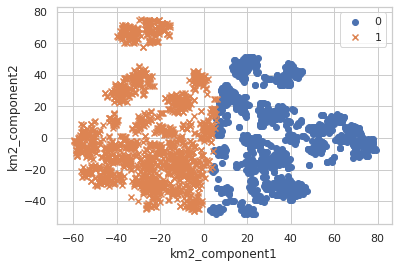

In [57]:
df2=X_km2_df
markers=['o','x']
for i, mark in enumerate(markers):
    df2_i=df2[df2['label_km2']==i]
    target_i=i
    X1=df2_i['km2_comp1']
    X2=df2_i['km2_comp2']
    plt.scatter(X1,X2,marker=mark, label=target_i)
    
plt.xlabel('km2_component1')
plt.ylabel('km2_component2')
plt.legend()
plt.show()

### 4. 데이터셋 생성

In [77]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [78]:
train_dataset = MyDataset(df=train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)

val_dataset = MyDataset(df = val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)

### 5. 1D AutoEncoder

In [79]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(30,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,30),
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

### 6. training

In [80]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        
    def fit(self, ):
        self.model.to(self.device)
        best_score = 0
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()

                _x = self.model(x)
                loss = self.criterion(x, _x)

                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            score = self.validation(self.model, 0.95)
            print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val Score : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score < score:
                best_score = score
                torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
    
    def validation(self, eval_model, thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        eval_model.eval()
        pred = []
        true = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)

                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
                pred += batch_pred
                true += y.tolist()

        return f1_score(true, pred, average='macro')

### 7. 모델 학습

In [84]:
model = nn.DataParallel(AutoEncoder())
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-2, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.56115003994533] Val Score : [0.0010529271374420891])
Epoch : [1] Train loss : [0.3738866831575121] Val Score : [0.05587333624237573])
Epoch : [2] Train loss : [0.28093824642045157] Val Score : [0.2854657599453707])
Epoch : [3] Train loss : [0.2224659217255456] Val Score : [0.3801950750574852])
Epoch : [4] Train loss : [0.18931935940470015] Val Score : [0.43729395863287074])
Epoch : [5] Train loss : [0.16893685502665384] Val Score : [0.4740873039911021])
Epoch : [6] Train loss : [0.1536491002355303] Val Score : [0.48623849655384355])
Epoch : [7] Train loss : [0.14252223074436188] Val Score : [0.49528468183435154])
Epoch : [8] Train loss : [0.1329272985458374] Val Score : [0.4992141383647151])
Epoch : [9] Train loss : [0.1258907328758921] Val Score : [0.502841724590064])
Epoch : [10] Train loss : [0.1212686789887292] Val Score : [0.5061658060209104])
Epoch : [11] Train loss : [0.11596391775778361] Val Score : [0.5086751474911252])
Epoch : [12] Train loss : [0.

KeyboardInterrupt: 

### 8. 추론

In [ ]:
model = AutoEncoder()
model.load_state_dict(torch.load('./best_model.pth'))
model = nn.DataParallel(model)
model.eval()